# Applying Approaches

In [26]:
# General
import numpy as np
import matplotlib.pyplot as plt
from keras import ops
from rich.table import Table

# Dataset
from sklearn.preprocessing import MinMaxScaler
from hml.datasets import load_dataset

# Approaches
from hml.approaches import CutAndCount as CNC
from hml.approaches import GradientBoostedDecisionTree as BDT
from hml.approaches import SimpleCNN as CNN
from hml.approaches import SimpleMLP as MLP

# Evaluation
from keras.metrics import Accuracy, AUC
from sklearn.metrics import roc_curve
from hml.metrics import MaxSignificance, RejectionAtEfficiency

# Save and load
from hml.approaches import load_approach

In [27]:
results = {}


def get_result(approach, x_test, y_test):
    y_pred = approach.predict(x_test, verbose=0)

    fpr, tpr, _ = roc_curve(y_test, y_pred[:, 1])

    result = {
        approach.name: {
            "acc": ops.convert_to_numpy(
                Accuracy()(y_test, y_pred.argmax(axis=1))
            ).item(),
            "auc": ops.convert_to_numpy(AUC()(y_test, y_pred[:, 1])).item(),
            "sig": ops.convert_to_numpy(MaxSignificance()(y_test, y_pred)).item(),
            "r50": ops.convert_to_numpy(
                RejectionAtEfficiency(0.5)(y_test, y_pred)
            ).item(),
            "r99": ops.convert_to_numpy(
                RejectionAtEfficiency(0.99)(y_test, y_pred)
            ).item(),
            "fpr": fpr,
            "tpr": tpr,
        }
    }

    return result

## Cut and count

In [3]:
ds = load_dataset("./data/wjj_vs_qcd_set.ds")

x_train, y_train = ds.train.samples, ds.train.targets
x_test, y_test = ds.test.samples, ds.test.targets

In [4]:
cnc1 = CNC(
    n_observables=3,
    topology="parallel",
    name="cnc_parallel",
)
cnc1.compile(
    optimizer="adam",
    loss="crossentropy",
    metrics=["accuracy"],
    run_eagerly=True,
)
cnc1.fit(x_train, y_train, batch_size=len(x_train))

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step - accuracy: 0.7631 - loss: 3.8179


In [5]:
cnc2 = CNC(
    n_observables=3,
    topology="sequential",
    name="cnc_sequential",
)
cnc2.compile(
    optimizer="adam",
    loss="crossentropy",
    metrics=["accuracy"],
    run_eagerly=True,
)
cnc2.fit(x_train, y_train, batch_size=len(x_train))

/root/miniconda3/envs/py39/lib/python3.9/site-packages/keras/src/layers/layer.py:360: UserWarning: `build()` was called on layer 'cnc_sequential', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - accuracy: 0.7968 - loss: 3.2749


In [6]:
results.update(get_result(cnc1, x_test, y_test))
results.update(get_result(cnc2, x_test, y_test))

## Gradient boosted decision tree

In [7]:
ds = load_dataset("./data/wjj_vs_qcd_set.ds")

x_train, y_train = ds.train.samples, ds.train.targets
x_test, y_test = ds.test.samples, ds.test.targets

In [8]:
bdt = BDT(name="bdt")
bdt.compile(metrics=["accuracy"])
bdt.fit(x_train, y_train)

100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 0.2807 - accuracy: 0.9005


History(history=defaultdict(<class 'list'>, {'loss': [0.6296028859536483, 0.5804393850203127, 0.5393955006278445, 0.5046407520696867, 0.47491376526785767, 0.449410907522138, 0.4276972269262197, 0.40843946310729745, 0.39207412799169983, 0.37705033703827173, 0.36387055727287815, 0.3526684711641016, 0.34255276390440614, 0.333618743151885, 0.32551184570356645, 0.3185567483386983, 0.3118609623677427, 0.3061747566869114, 0.30076177225027984, 0.29624128846265624, 0.29227015022050634, 0.28842943684766054, 0.28520770207274065, 0.2818053732145559, 0.2787620299905422, 0.27562083755884104, 0.2734479332450524, 0.2713332989853182, 0.2694232645242636, 0.26776779653643995, 0.26643187299384896, 0.26491353148533797, 0.26356261422381316, 0.26222755945913634, 0.26111963489754475, 0.26014293442010783, 0.2587989990402263, 0.2576761125514173, 0.25638365647291317, 0.255678792157077, 0.2547602407991811, 0.2541201975475863, 0.2534759878634051, 0.25270265961862487, 0.25207314071007786, 0.2516224333420763, 0.2509

In [9]:
results.update(get_result(bdt, x_test, y_test))

## Simple multi-layer perceptron

In [10]:
ds = load_dataset("./data/wjj_vs_qcd_set.ds")

x_train, y_train = ds.train.samples, ds.train.targets
x_test, y_test = ds.test.samples, ds.test.targets

scaler = MinMaxScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

In [11]:
mlp = MLP(name="mlp", input_shape=x_train.shape[1:])
mlp.summary()

Model: "mlp"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 32)             │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 2)              │            66 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,386 (17.13 KB)

 Trainable params: 4,386 (17.13 KB)

 Non-trainable params: 0 (0.00 B)

In [12]:
mlp.compile(loss="crossentropy", metrics=["accuracy"])
mlp.fit(x_train, y_train, batch_size=128, epochs=100)

Epoch 1/100


99/99 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.7073 - loss: 0.5788
Epoch 2/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8625 - loss: 0.3370
Epoch 3/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8816 - loss: 0.2869
Epoch 4/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8811 - loss: 0.2853
Epoch 5/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8829 - loss: 0.2868
Epoch 6/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8914 - loss: 0.2730
Epoch 7/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8873 - loss: 0.2782
Epoch 8/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8883 - loss: 0.2781
Epoch 9/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8850 - loss: 0.2783
Epoch 10/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8894 - loss: 0.2799
Epoch 11/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8906 - loss: 0.2747
Epoch 12/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8906 - lo

In [13]:
results.update(get_result(mlp, x_test, y_test))

## Simple convolutional neural network

In [14]:
ds = load_dataset("./data/wjj_vs_qcd_image.ds")

x_train, y_train = ds.train.samples, ds.train.targets
x_test, y_test = ds.test.samples, ds.test.targets

non_zero_train = x_train.reshape(x_train.shape[0], -1).sum(1) != 0
non_zero_test = x_test.reshape(x_test.shape[0], -1).sum(1) != 0

x_train, y_train = x_train[non_zero_train], y_train[non_zero_train]
x_test, y_test = x_test[non_zero_test], y_test[non_zero_test]

x_train = (
    x_train.reshape(len(x_train), -1)
    / x_train.reshape(len(x_train), -1).max(1, keepdims=True)
).reshape(x_train.shape)
x_test = (
    x_test.reshape(len(x_test), -1)
    / x_test.reshape(len(x_test), -1).max(1, keepdims=True)
).reshape(x_test.shape)
x_train = x_train[..., None]
x_test = x_test[..., None]

In [15]:
cnn1 = CNN(name="cnn_max", input_shape=x_train.shape[1:])
cnn1.summary()

Model: "cnn_max"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 33, 33, 8)      │            80 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 16, 16, 16)     │         1,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 8, 8, 32)       │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 4, 4, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 32)             │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 2)              │            66 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 2)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,960 (23.28 KB)

 Trainable params: 5,960 (23.28 KB)

 Non-trainable params: 0 (0.00 B)

In [16]:
cnn1.compile(
    optimizer="adam",
    loss="crossentropy",
    metrics=["accuracy"],
)

cnn1.fit(
    x_train,
    y_train,
    epochs=100,
    batch_size=128,
)

Epoch 1/100


/root/miniconda3/envs/py39/lib/python3.9/site-packages/keras/src/layers/layer.py:360: UserWarning: `build()` was called on layer 'cnn_max', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


98/98 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - accuracy: 0.5386 - loss: 0.6891
Epoch 2/100
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5982 - loss: 0.6491
Epoch 3/100
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7270 - loss: 0.5965
Epoch 4/100
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7502 - loss: 0.5658
Epoch 5/100
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7660 - loss: 0.5437
Epoch 6/100
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7618 - loss: 0.5395
Epoch 7/100
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7704 - loss: 0.5309
Epoch 8/100
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7847 - loss: 0.5135
Epoch 9/100
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7812 - loss: 0.5083
Epoch 10/100
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7817 - loss: 0.5065
Epoch 11/100
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7899 - loss: 0.4941
Epoch 12/100
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7856 - l

In [17]:
results.update(get_result(cnn1, x_test, y_test))

In [ ]:
# Dataset
ds = load_dataset("./data/wjj_vs_qcd_image.ds")

x_train, y_train = ds.train.samples, ds.train.targets
x_test, y_test = ds.test.samples, ds.test.targets

non_zero_train = x_train.reshape(x_train.shape[0], -1).sum(1) != 0
non_zero_test = x_test.reshape(x_test.shape[0], -1).sum(1) != 0

x_train, y_train = x_train[non_zero_train], y_train[non_zero_train]
x_test, y_test = x_test[non_zero_test], y_test[non_zero_test]

x_train = np.log(x_train + 1)
x_test = np.log(x_test + 1)
x_train = x_train[..., None]
x_test = x_test[..., None]

In [18]:
cnn2 = CNN(name="cnn_log", input_shape=x_train.shape[1:])

cnn2.compile(
    optimizer="adam",
    loss="crossentropy",
    metrics=["accuracy"],
)

cnn2.fit(
    x_train,
    y_train,
    epochs=100,
    batch_size=128,
)

Epoch 1/100


/root/miniconda3/envs/py39/lib/python3.9/site-packages/keras/src/layers/layer.py:360: UserWarning: `build()` was called on layer 'cnn_log', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


98/98 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.5350 - loss: 0.6880
Epoch 2/100
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6368 - loss: 0.6431
Epoch 3/100
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7278 - loss: 0.5933
Epoch 4/100
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7648 - loss: 0.5535
Epoch 5/100
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7704 - loss: 0.5377
Epoch 6/100
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7795 - loss: 0.5242
Epoch 7/100
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7802 - loss: 0.5144
Epoch 8/100
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7842 - loss: 0.5128
Epoch 9/100
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7853 - loss: 0.5014
Epoch 10/100
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7883 - loss: 0.5030
Epoch 11/100
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7892 - loss: 0.4951
Epoch 12/100
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7892 - l

In [19]:
results.update(get_result(cnn2, x_test, y_test))

## Evaluation

In [20]:
table = Table(
    "Name",
    "ACC",
    "AUC",
    "Significance",
    "R50",
    "R99",
    title="Approach Comparison",
)

for name, metrics in results.items():
    table.add_row(
        name,
        f"{metrics['acc']:.6f}",
        f"{metrics['auc']:.6f}",
        f"{metrics['sig']:.6f}",
        f"{metrics['r50']:.6f}",
        f"{metrics['r99']:.6f}",
    )

table

                             Approach Comparison                              
┏━━━━━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━┓
┃ Name           ┃ ACC      ┃ AUC      ┃ Significance ┃ R50       ┃ R99      ┃
┡━━━━━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━┩
│ cnc_parallel   │ 0.765086 │ 0.743599 │ 34.742661    │ 4.256874  │ 1.000000 │
│ cnc_sequential │ 0.805868 │ 0.788848 │ 37.796890    │ 5.151141  │ 1.000000 │
│ bdt            │ 0.899797 │ 0.952525 │ 44.131214    │ 86.015831 │ 1.997420 │
│ mlp            │ 0.897583 │ 0.952662 │ 44.056389    │ 96.767815 │ 1.953497 │
│ cnn_max        │ 0.806482 │ 0.868102 │ 38.510403    │ 16.526314 │ 1.191518 │
│ cnn_log        │ 0.808917 │ 0.873000 │ 38.833694    │ 17.852850 │ 1.232795 │
└────────────────┴──────────┴──────────┴──────────────┴───────────┴──────────┘

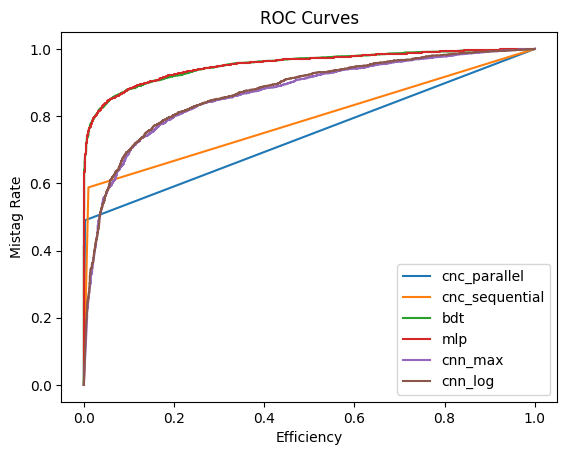

In [22]:
for name, metrics in results.items():
    fpr = metrics["fpr"]
    tpr = metrics["tpr"]
    plt.plot(fpr, tpr, label=f"{name}")

plt.title("ROC Curves")
plt.xlabel("Efficiency")
plt.ylabel("Mistag Rate")
plt.legend()
plt.show()

## Plot the cuts on distributions

In [23]:
ds = load_dataset("./data/wjj_vs_qcd_set.ds")

x_train, y_train = ds.train.samples, ds.train.targets
x_test, y_test = ds.test.samples, ds.test.targets

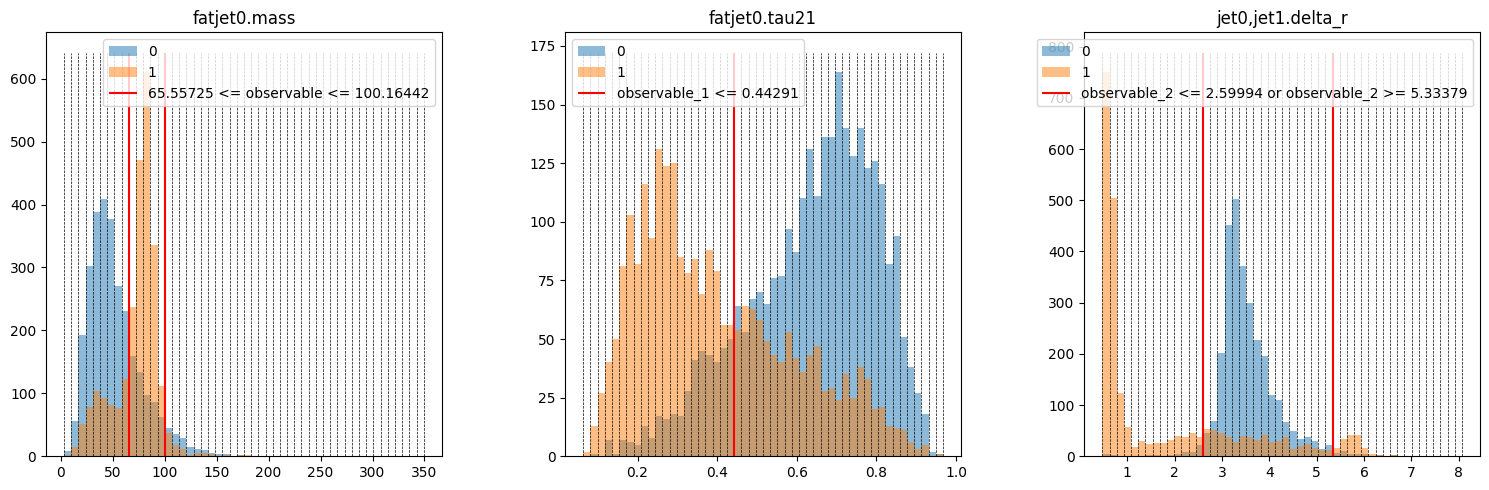

In [24]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
for i in range(x_train.shape[1]):
    layer = cnc1.cut_layers[i]

    observable = ds.feature_names[i]
    bin_edges = np.linspace(x_train[:, i].min(), x_train[:, i].max(), cnc1.n_bins + 1)

    axs[i].hist(x_test[:, i][y_test == 0], bins=bin_edges, alpha=0.5, label="0")
    axs[i].hist(x_test[:, i][y_test == 1], bins=bin_edges, alpha=0.5, label="1")

    y_min, y_max = axs[i].get_ylim()
    axs[i].vlines(bin_edges, y_min, y_max, color="k", ls="dashed", lw=0.5)

    if layer.case == 0:
        axs[i].vlines(layer.cut_left, y_min, y_max, color="r", label=layer.cut)
    elif layer.case == 1:
        axs[i].vlines(layer.cut_right, y_min, y_max, color="r", label=layer.cut)
    elif layer.case == 2:
        axs[i].vlines(layer.cut_left, y_min, y_max, color="r", label=layer.cut)
        axs[i].vlines(layer.cut_right, y_min, y_max, color="r")
    else:
        axs[i].vlines(layer.cut_left, y_min, y_max, color="r", label=layer.cut)
        axs[i].vlines(layer.cut_right, y_min, y_max, color="r")

    axs[i].set_title(f"{observable}")
    axs[i].legend()

plt.tight_layout()
plt.show()

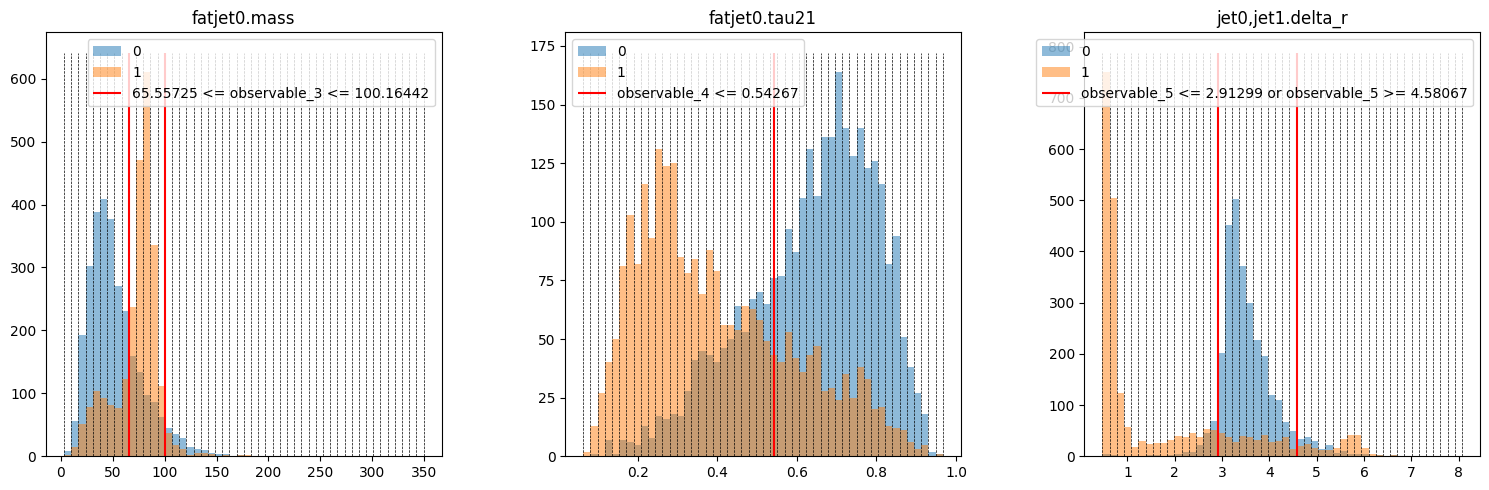

In [25]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
for i in range(x_train.shape[1]):
    layer = cnc2.cut_layers[i]

    observable = ds.feature_names[i]
    bin_edges = np.linspace(x_train[:, i].min(), x_train[:, i].max(), cnc2.n_bins + 1)

    axs[i].hist(x_test[:, i][y_test == 0], bins=bin_edges, alpha=0.5, label="0")
    axs[i].hist(x_test[:, i][y_test == 1], bins=bin_edges, alpha=0.5, label="1")

    y_min, y_max = axs[i].get_ylim()
    axs[i].vlines(bin_edges, y_min, y_max, color="k", ls="dashed", lw=0.5)

    if layer.case == 0:
        axs[i].vlines(layer.cut_left, y_min, y_max, color="r", label=layer.cut)
    elif layer.case == 1:
        axs[i].vlines(layer.cut_right, y_min, y_max, color="r", label=layer.cut)
    elif layer.case == 2:
        axs[i].vlines(layer.cut_left, y_min, y_max, color="r", label=layer.cut)
        axs[i].vlines(layer.cut_right, y_min, y_max, color="r")
    else:
        axs[i].vlines(layer.cut_left, y_min, y_max, color="r", label=layer.cut)
        axs[i].vlines(layer.cut_right, y_min, y_max, color="r")

    axs[i].set_title(f"{observable}")
    axs[i].legend()

plt.tight_layout()
plt.show()

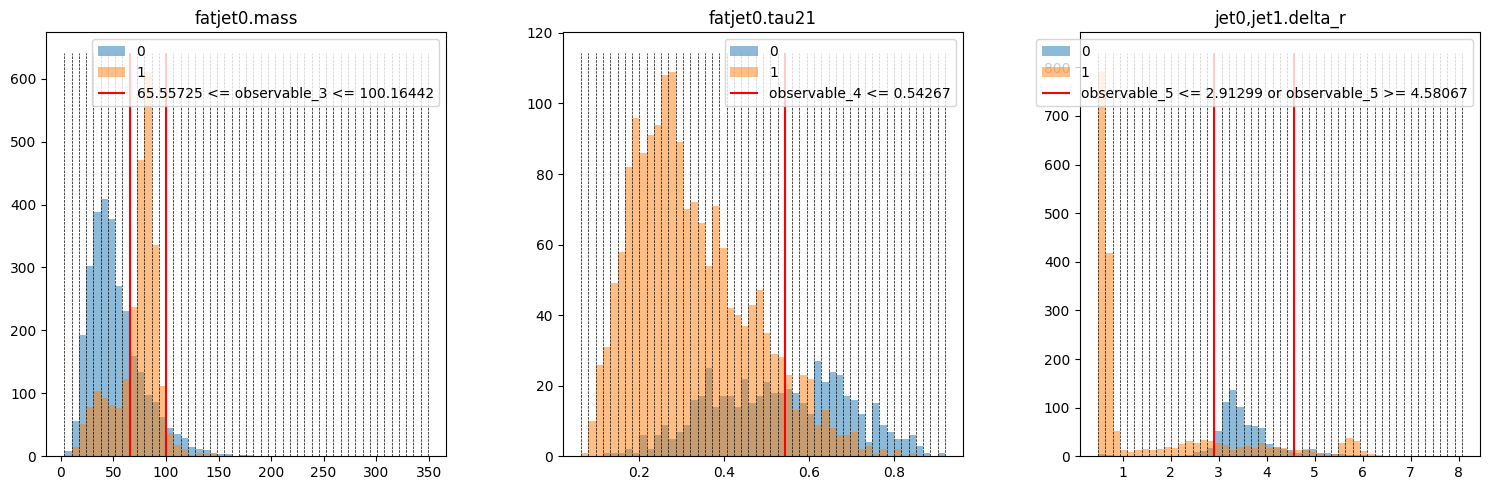

In [28]:
cut_layers = cnc2.cut_layers
mask_train = ops.squeeze(ops.where(ops.ones(x_train.shape[0]) == 1))
mask_test = ops.squeeze(ops.where(ops.ones(x_test.shape[0]) == 1))

plt.figure(figsize=(15, 5))
for i in range(x_train.shape[1]):
    plt.subplot(1, 3, i + 1)
    layer = cut_layers[i]

    masked_x_train = ops.convert_to_numpy(ops.take(x_train[:, i], mask_train))
    masked_y_train = ops.convert_to_numpy(ops.take(y_train, mask_train))
    bin_edges = np.linspace(masked_x_train.min(), masked_x_train.max(), 50 + 1)
    mask_train = ops.squeeze(ops.where(cut_layers[i].apply_cut(x_train) == 1))

    masked_x_test = ops.convert_to_numpy(ops.take(x_test[:, i], mask_test))
    masked_y_test = ops.convert_to_numpy(ops.take(y_test, mask_test))
    mask_test = ops.squeeze(ops.where(cut_layers[i].apply_cut(x_test) == 1))

    plt.hist(masked_x_test[masked_y_test == 0], bins=bin_edges, alpha=0.5, label="0")
    plt.hist(masked_x_test[masked_y_test == 1], bins=bin_edges, alpha=0.5, label="1")

    y_min, y_max = plt.gca().get_ylim()
    plt.vlines(bin_edges, y_min, y_max, color="k", ls="dashed", lw=0.5)

    if layer.case == 0:
        plt.vlines(layer.cut_left, y_min, y_max, color="r", label=layer.cut)
    elif layer.case == 1:
        plt.vlines(layer.cut_left, y_min, y_max, color="r", label=layer.cut)
    elif layer.case == 2:
        plt.vlines(layer.cut_left, y_min, y_max, color="r", label=layer.cut)
        plt.vlines(layer.cut_right, y_min, y_max, color="r")
    else:
        plt.vlines(layer.cut_left, y_min, y_max, color="r", label=layer.cut)
        plt.vlines(layer.cut_right, y_min, y_max, color="r")

    plt.title(ds.feature_names[i])
    plt.legend()
plt.tight_layout()
plt.show()

## Save and load approaches

In [29]:
cnc1.save("./checkpoints/cnc_parallel.keras")
cnc2.save("./checkpoints/cnc_sequential.keras")
bdt.save("./checkpoints/bdt.pickle")
mlp.save("./checkpoints/mlp.keras")
cnn1.save("./checkpoints/cnn1.keras")
cnn2.save("./checkpoints/cnn2.keras")

In [30]:
loaded_cnc1 = load_approach("./checkpoints/cnc_parallel.keras")
loaded_cnc2 = load_approach("./checkpoints/cnc_sequential.keras")
loaded_bdt = load_approach("./checkpoints/bdt.pickle")
loaded_mlp = load_approach("./checkpoints/mlp.keras")
loaded_cnn1 = load_approach("./checkpoints/cnn1.keras")
loaded_cnn2 = load_approach("./checkpoints/cnn2.keras")